# Recursos Especiais baixados interpostos pelo MPSP
### 16/06/2022

O presente notebook buscou obter os resultados dos recursos especiais interpostos pelo MPSP.

A análise foi feita a partir de dataset gerado pelo STJ, filtrando-se 1000 processos que tinham o MPSP como parte ou interessado, já baixados (pois a intenção era a de conhecer o desfecho), em ordem cronológica descendente da data da última movimentação. O arquivo "csv" foi gerado pelo STJ no dia 16 jun. 2022.

O codigo foi escrito em Python. Foram utilizadas as bibliotecas pandas (para as operações com o dataframe), matplotlib (para os gráficos), requests (para as requisições http ao site do STJ) e beautifulsoup (para a extração dos dados dos documentos html recuperados).


In [1]:
# Importação das bibliotecas necessárias

import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

In [2]:
# Criação do dataframe

df = pd.read_csv('processosSTJ.csv', parse_dates=['Data Autuação'])
df = df.dropna(subset='Processo') # Exclusão dos registros sem o nº de processo.

In [3]:
print(f'Total de processos encontrados: {len(df)}')

Total de processos encontrados: 992


In [4]:
df.sample(5)

,Número de Registro,Número Único,Processo,Nome Parte Autora,Nome Parte Ré,Data da Última Fase,Fase,Tramitando,Orgão Julgador,Segredo de Justiça,Ministro Relator,Observações,Data Autuação
153,202200459580,15001584920208260561,REsp 1986642,JOAO VITOR DE ANDRADE RODRIGUES,MINISTÉRIO PÚBLICO DO ESTADO DE SÃO PAULO,2022-06-02T10:12:19.000+0000,Baixa Definitiva para TRIBUNAL DE JUSTIÇA DO E...,N,SEXTA TURMA,N,ROGERIO SCHIETTI CRUZ,NaN,2022-02-24
554,202103664140,15095383820208260451,REsp 1970766,MINISTÉRIO PÚBLICO DO ESTADO DE SÃO PAULO,W A DE L C,2022-04-21T00:11:38.000+0000,Baixa Definitiva para TRIBUNAL DE JUSTIÇA DO E...,N,SEXTA TURMA,S,OLINDO MENEZES (DESEMBARGADOR CONVOCADO DO TRF...,NaN,2021-11-16
74,202101671700,00015967620158260589,REsp 1941484,D B,MINISTÉRIO PÚBLICO DO ESTADO DE SÃO PAULO,2022-06-13T04:23:34.000+0000,MINISTÉRIO PÚBLICO FEDERAL intimado eletronica...,N,SEXTA TURMA,S,LAURITA VAZ,NaN,2021-05-30
227,202103756603,00014519320188260369,REsp 1973117,J R S,MINISTÉRIO PÚBLICO DO ESTADO DE SÃO PAULO,2022-05-26T18:22:15.000+0000,Baixa Definitiva para TRIBUNAL DE JUSTIÇA DO E...,N,QUINTA TURMA,S,REYNALDO SOARES DA FONSECA,NaN,2021-11-24
107,202002262895,10048191820178260664,REsp 1893363,CALIMERIO LUIZ CORREA SALES,MINISTÉRIO PÚBLICO DO ESTADO DE SÃO PAULO,2022-06-08T00:52:19.000+0000,Baixa Definitiva para TRIBUNAL DE JUSTIÇA DO E...,N,PRIMEIRA TURMA,N,BENEDITO GONÇALVES,NaN,2020-09-02



### Dos 992 processos de RESp recuperados, constata-se que 192 têm o MPSP como autor:

In [5]:
df['Nome Parte Autora'].value_counts()

MINISTÉRIO PÚBLICO DO ESTADO DE SÃO PAULO    192
MUNICÍPIO DE GUARULHOS                         2
FAZENDA DO ESTADO DE SÃO PAULO                 2
FUNDAÇÃO SÃO PAULO                             2
ROGERIO DA SILVA FERREIRA                      2
                                            ... 
MARIA APARECIDA DE SOUSA CARDOSO               1
WILHA LOPES SANTOS                             1
WALT DISNEY DA SILVA                           1
JOSÉ LÁZARO VICTAL DO PRADO                    1
CAIOM EDUARDO DA SILVA BURGHETI                1
Name: Nome Parte Autora, Length: 796, dtype: int64

### Restringindo o DF aos casos de REsp em que o MPSP é o autor

In [6]:
criterio = df['Nome Parte Autora'] == 'MINISTÉRIO PÚBLICO DO ESTADO DE SÃO PAULO'
df = df[criterio]
df['Número de Registro'] = df['Número de Registro'].astype(str)

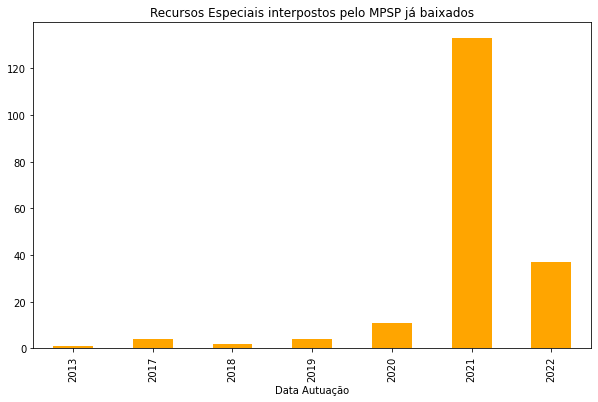

In [7]:
agrupamento_ano = df.groupby(df['Data Autuação'].dt.year)['Processo'].count()
agrupamento_ano.plot.bar(title='Recursos Especiais interpostos pelo MPSP já baixados', 
                         color='orange', figsize =(10,6))
plt.savefig('REsp.jpg')
plt.show()

In [8]:
# Funções para o webscraping

def requisita_monocratica(registro):
    """Retorna o texto da decisão monocrática em para o registro fornecido"""
    response = requests.post(f'https://scon.stj.jus.br/SCON/pesquisar.jsp?livre={registro}&b=DTXT&p=true&tp=T')
    html = response.text # ver: https://stackoverflow.com/questions/17011357/what-is-the-difference-between-content-and-text 
    return html

def requisita_acordao(registro):
    """Retorna o texto do acórdao ou ementa para o registro fornecido"""
    response = requests.post(f'https://scon.stj.jus.br/SCON/pesquisar.jsp?livre={registro}&b=ACOR&p=true&tp=T')
    html = response.text # ver: https://stackoverflow.com/questions/17011357/what-is-the-difference-between-content-and-text 
    return html

def encontra_conteudo (html):
    """Retorna o conteúdo da id em formato texto e sem as tags do html"""
    soup = BeautifulSoup(html, 'html.parser')
    conteudo = soup.find(id="Semformatacao1") # com as tags
    return conteudo.text # sem as tags

### Preparando o dataframe para a raspagem das decisões monocráticas e acórdãos...

In [9]:
df['Monocrática'] = ''
df['Acórdão'] = ''

In [10]:
# Percorrendo o dataframe

for i in df.index:
    registro = df.loc[i, 'Número de Registro']
    html = requisita_monocratica(registro)
    try:
        df.loc[i, 'Monocrática'] = encontra_conteudo(html)
    except:
        df.loc[i, 'Monocrática'] = 'Não encontrado'
    html = requisita_acordao(registro)
    try:
        df.loc[i, 'Acórdão'] = encontra_conteudo(html)
    except:
        df.loc[i, 'Acórdão'] = 'Não encontrado'

In [11]:
df.sample(5)

,Número de Registro,Número Único,Processo,Nome Parte Autora,Nome Parte Ré,Data da Última Fase,Fase,Tramitando,Orgão Julgador,Segredo de Justiça,Ministro Relator,Observações,Data Autuação,Monocrática,Acórdão
149,202103918110,15000289320218260312,REsp 1977124,MINISTÉRIO PÚBLICO DO ESTADO DE SÃO PAULO,L A DA S F,2022-06-02T20:04:34.000+0000,Baixa Definitiva para TRIBUNAL DE JUSTIÇA DO E...,N,SEXTA TURMA,S,ROGERIO SCHIETTI CRUZ,NaN,2021-12-07,\n\r\nRECURSO ESPECIAL Nº 1977124 - SP (2021/0...,\n\r\nRECURSO ESPECIAL. MULHER TRANS. VÍTIMA D...
884,202003330118,20252449620208260000,REsp 1911233,MINISTÉRIO PÚBLICO DO ESTADO DE SÃO PAULO,L A O,2022-03-18T11:09:30.000+0000,Baixa Definitiva para TRIBUNAL DE JUSTIÇA DO E...,N,NaN,S,VICE-PRESIDENTE DO STJ,NaN,2020-12-10,\n\r\nARE no RE no AgRg no RECURSO ESPECIAL Nº...,\n\r\nPENAL E PROCESSUAL PENAL. AGRAVO REGIMEN...
331,202200764990,00030621820178260466,REsp 1991609,MINISTÉRIO PÚBLICO DO ESTADO DE SÃO PAULO,LEANDRO FERREIRA DOS SANTOS,2022-05-17T14:13:18.000+0000,Baixa Definitiva para TRIBUNAL DE JUSTIÇA DO E...,N,SEXTA TURMA,N,ROGERIO SCHIETTI CRUZ,NaN,2022-03-21,\n\r\nRECURSO ESPECIAL Nº 1991609 - SP (2022/0...,Não encontrado
893,202103991552,00176570920178260050,REsp 1977874,MINISTÉRIO PÚBLICO DO ESTADO DE SÃO PAULO,ANDERSON BEZERRA COSTA,2022-03-17T16:17:06.000+0000,Baixa Definitiva para TRIBUNAL DE JUSTIÇA DO E...,N,QUINTA TURMA,N,REYNALDO SOARES DA FONSECA,NaN,2021-12-17,\n\r\nRECURSO ESPECIAL Nº 1977874 - SP (2021/0...,\n\r\nPENAL. AGRAVO REGIMENTAL NO RECURSO ESPE...
390,202103083198,00006333920208260154,REsp 1962413,MINISTÉRIO PÚBLICO DO ESTADO DE SÃO PAULO,JOSE RICARDO DA SILVA JUNIOR,2022-05-09T18:11:20.000+0000,Baixa Definitiva para TRIBUNAL DE JUSTIÇA DO E...,N,SEXTA TURMA,N,SEBASTIÃO REIS JÚNIOR,NaN,2021-09-22,\n\r\nRECURSO ESPECIAL Nº 1962413 - SP (2021/0...,Não encontrado


In [12]:
# Exportando o resultado para planilha Excel

df.to_excel('REsp.xlsx', engine='xlsxwriter')

In [13]:
# Exportando o resultado para arquivo texto

with open ('REsp.txt', 'w') as f:
    f.write(f"RELATÓRIO DE RECURSOS ESPECIAIS BAIXADOS INTERPOSTOS PELO MPSP\n\n")
    f.write(f"- Nº de processos pesquisados: {len(df)}\n\n")
    f.write("__________\n\n")
    
    for i in df.index:
        f.write(f"Data Autuação: {df['Data Autuação'][i]} - Processo: {df['Processo'][i]}\n")
        f.write(f"Ministro Relator: {df['Ministro Relator'][i]} - Órgão Julgador: {df['Orgão Julgador'][i]}\n")
        f.write(f"Nome Parte Ré: {df['Nome Parte Ré'][i]}\n")
        f.write(f"Data da Última Fase: {str(df['Data da Última Fase'][i])[0:10]}\n")
        f.write("__________\n\n")
        f.write(f"DECISÃO MONOCRÁTICA:\n{df['Monocrática'][i]}\n\n")
        f.write(f"ACÓRDÃO:\n{df['Acórdão'][i]}\n")
        f.write(f"\n**************** Fim dos dados do {df['Processo'][i]} ****************\n\n")